In [121]:
from pepys_import.core.store.data_store import DataStore
import pandas as pd
from sqlalchemy import create_engine
import geopandas as gpd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import hvplot
import hvplot.pandas

## Create DataStore object, and older-style SQLAlchemy object

In [81]:
ds = DataStore("tracstor_view", "View1001View", "trac-store.com", 5432, "tracstor_trial1", "postgres")

   @@@@ @@@@@        ______                      _                            _   
 @@@@@ @@..@@@@      | ___ \                    (_)                          | |  
  @@@     @@@@@@     | |_/ /__ _ __  _   _ ___   _ _ __ ___  _ __   ___  _ __| |_ 
  @@@     @@@@@@@@   |  __/ _ \ '_ \| | | / __| | | '_ ` _ \| '_ \ / _ \| '__| __|
 @@@@.     @@@@@@@   | | |  __/ |_) | |_| \__ \ | | | | | | | |_) | (_) | |  | |_ 
 @@ #@@ @   ...@@@@@ \_|  \___| .__/ \__, |___/ |_|_| |_| |_| .__/ \___/|_|   \__|
 @@   &        @@@@@            | |     __/ | ______          | |                   
Software Version :  0.0.32



Database Type :  postgres
Database Name :  tracstor_trial1
Database Host :  trac-store.com
------------------------------------------------------------------------------


In [3]:
engine = create_engine(ds.connection_string, future=False)

## Functions for plotting platforms and datafiles

In [90]:
def plot_platform(platform_id):
    sql = f"SELECT * FROM pepys.states_for(null, null, null, null, null, '{{{platform_id}}}')"
    data = gpd.read_postgis(sql,
                            engine, geom_col='state_location')
    data['time_str'] = data.state_time.astype(str)
    data = data.dropna(subset=['state_location'])
    if len(data) == 0:
        return "No data"
    m = data[['time_str', 'state_location', 'heading', 'course', 'speed']].explore(column='speed')
    return m

In [97]:
def plot_datafile(datafile_id):
    sql = f"SELECT * FROM pepys.states_for(null, null, null, null, '{{{datafile_id}}}', null)"
    data = gpd.read_postgis(sql,
                            engine, geom_col='state_location')
    data['time_str'] = data.state_time.astype(str)
    if len(data) == 0:
        return "No data"
    data = data.dropna(subset=['state_location'])
    m = data[['time_str', 'state_location', 'heading', 'course', 'speed']].explore(column='speed')
    return m

## Interactive UI to select platform and see plot

In [82]:
with ds.session_scope():
    platforms = ds.session.query(ds.db_classes.Platform.name, ds.db_classes.Platform.platform_id).all()

In [84]:
platforms = [(name, str(plat_id)) for name, plat_id in platforms]

In [91]:
interact(plot_platform, platform_id=platforms)

interactive(children=(Dropdown(description='platform_id', options=(('GreenFV1_003', '84364da3-f52b-4ba2-92eb-5…

<function __main__.plot_platform(platform_id)>

## Interactive UI to select datafile and see plot

In [93]:
with ds.session_scope():
    datafiles = ds.session.query(ds.db_classes.Datafile.reference, ds.db_classes.Datafile.datafile_id).all()

In [94]:
datafiles = [(name, str(df_id)) for name, df_id in datafiles]

In [98]:
interact(plot_datafile, datafile_id=datafiles)

interactive(children=(Dropdown(description='datafile_id', options=(('ForceProt_3_31_201130_111758.880.rep', '5…

<function __main__.plot_datafile(datafile_id)>

## Data plots for the HIPP platform

#### Example static plot using matplotlib

In [102]:
hipp_id = dict(platforms)['HIPP']

In [103]:
sql = f"SELECT * FROM pepys.states_for(null, null, null, null, null, '{{{hipp_id}}}')"
data = gpd.read_postgis(sql,
                        engine, geom_col='state_location')

Text(0.5, 1.0, 'Example static plot')

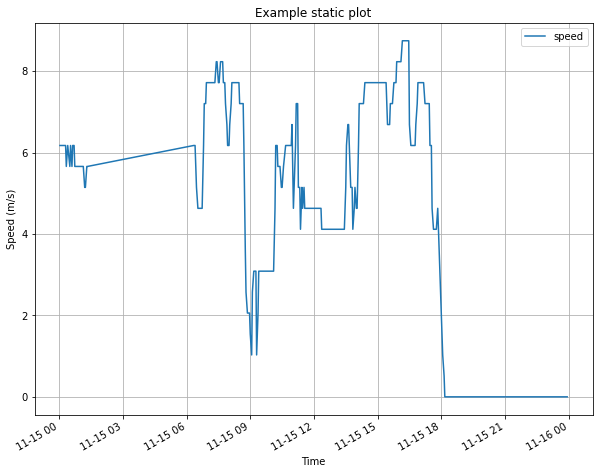

In [114]:
_ = data.plot(kind='line', x='state_time', y='speed', grid=True, figsize=(10, 8))
plt.xlabel("Time")
plt.ylabel("Speed (m/s)")
plt.title("Example static plot")

#### Example interactive plot using hvplot

In [123]:
pd.options.plotting.backend = 'hvplot'

In [151]:
df = pd.DataFrame(data)

In [160]:
df = df.set_index(df.state_time)

In [162]:
df = df.sort_index()

In [175]:
df.plot(kind='line', y='speed', label="Raw speed", grid=True, title="Example interactive plot (speed vs time)", xlabel="Time", ylabel="Speed (m/s)") * df.speed.rolling(10).mean().plot(kind='line', label="Smoothed speed")

:Overlay
   .Curve.Raw_speed      :Curve   [state_time]   (speed)
   .Curve.Smoothed_speed :Curve   [state_time]   (speed)